# Planning and Reasoning Project
## Path Planning with Dynamic Obstacles using Velocity Obstacles (VO) and Nonlinear Model Predictive Control (NMPC)
**Leandro Maglianella - 1792507**

> *This project is supposed to be executed in Google Colab*






## Import

In [ ]:
! rm -rf sample_data

# main libraries for the task
import numpy as np
np.random.seed(0)
from scipy.optimize import minimize, Bounds

# random for random theta for obstacles' configuration "random"
import random
random.seed(0)
# tqdm to monitor advancements
from tqdm import tqdm

# create_video libraries
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import datetime
import cv2
import glob
import os

print('Libraries imported.')

Libraries imported.


## Definitions

### Robot Class

This is the main class, it creates a round robot:
   - in position $p_0$
   - moving with an initial velocity $v_0$ and an initial direction given by $\theta_0$
   - the next $v_i$, with $i \in [1, n_{steps}]$ are decided by one of the two chosen planning algorithm:
    - **Velocity Obstacles** (VO)
    - **Nonlinear Model Predictive Control** (NMPC)

In [ ]:
class Robot:
  def __init__(self, p0, v0, theta0):
    self.positions = np.tile(p0, (NUMBER_OF_TIMESTEPS, 1))

    vx = v0 * np.cos(theta0)
    vy = v0 * np.sin(theta0)
    v = np.stack([vx, vy])
    self.velocities = np.tile(v, (NUMBER_OF_TIMESTEPS, 1))

    if ALGORITHM == 'vo':
      # Create search-space: discrete set of "all possible" velocities executable by the robot
      vels, thetas = np.meshgrid(np.linspace(0, VMAX, 5), np.linspace(0, 2*np.pi, 37))
      vels_x = (vels * np.cos(thetas)).flatten()
      vels_y = (vels * np.sin(thetas)).flatten()
      self.vo_executable_velocities = np.stack((vels_x, vels_y))

    if ALGORITHM == 'nmpc':
      self.nmpc_steps = [NMPC_TIMESTEP*i for i in range(1, HORIZON_LENGTH+1)]
      upper_bound = [(1/np.sqrt(2)) * VMAX] * 2
      lower_bound = [-(1/np.sqrt(2)) * VMAX] * 2
      self.nmpc_bounds = Bounds(lower_bound, upper_bound)

  def update_position(self, step):
    self.positions[step] = self.positions[step-1] + self.velocities[step] * TIMESTEP

  # ------------------------- HYBRID RECIPROCAL VELOCITY OBSTACLE METHODS -------------------------

  # find desired velocity (ignoring obstacles)
  def compute_velocity_desired(self, step, goal_pos):
    displacement = goal_pos - self.positions[step-1]
    disp_norm = np.linalg.norm(displacement)
    # did we arrive to the goal?
    if disp_norm < 0.1:
        self.velocities[step] = np.zeros(2)
    else:
        disp_versor = displacement / disp_norm
        self.velocities[step] = VMAX * disp_versor

  # find a safe velocity which is similar to the desired one
  def compute_velocity_safe(self, step, obstacles):
    # constraint matrix and vector
    Amat = np.empty((N_OBSTACLES * 2, 2))
    bvec = np.empty((N_OBSTACLES * 2))
    # Compute constraints for all the dynamic obstacles
    for i, obstacle in enumerate(obstacles):
        # compute theta and phi
        displacement = self.positions[step-1] - obstacle.positions[step-1]
        disp_norm = np.linalg.norm(displacement)
        thetaBA = np.arctan2(displacement[1], displacement[0])
        disp_norm = 2.5*ROBOT_RADIUS if disp_norm < 2.5 * ROBOT_RADIUS else disp_norm
        phi_obst = np.arcsin(2.5*ROBOT_RADIUS/disp_norm)
        # compute VO left constraints
        phi_left = thetaBA + phi_obst
        Amat[i*2, :] = np.array([np.sin(phi_left), -np.cos(phi_left)])
        bvec[i*2] = Amat[i*2, :] @ obstacle.velocities[step-1]
        # compute VO right constraints
        phi_right = thetaBA - phi_obst
        Amat[i*2 + 1, :] = np.array([-np.sin(phi_right), np.cos(phi_right)])
        bvec[i*2 + 1] = Amat[i*2 + 1, :] @ obstacle.velocities[step-1]
    # compute the set of all the safe velocities (i.e. the ones respecting the constraints)
    safe_velocities = self.respect_constraints(self.vo_executable_velocities, Amat, bvec)
    # final choice of safe velocity: the velocity that is closest to the desired one
    size = np.shape(safe_velocities)[1]
    displacements = safe_velocities - np.repeat(self.velocities[step].reshape(2, 1), size, axis=1)
    norms = np.linalg.norm(displacements, axis=0)
    min_index = np.where(norms == np.amin(norms))[0][0]
    self.velocities[step] = safe_velocities[:, min_index]

  def respect_constraints(self, velocities, Amat, bvec):
    for i in range(N_OBSTACLES):
        Amat_temp = Amat[2*i:2*i+2, :]
        bvec_temp = bvec[2*i:2*i+2]
        safe_velocities = []
        # check executable velocities (5*37 available velocities) against the 2 constraints of obstacle i
        # if there is no safe executable velocity, (0, 0) is performed and it is considered as an insecurity
        for i in range(np.shape(velocities)[1]): 
            if not ((Amat_temp @ velocities[:, i] < bvec_temp).all()):
                safe_velocities.append(velocities[:, i])
        velocities = np.array(safe_velocities).T
        if np.shape(velocities) == (0,):
          global UNSAFE_PATH
          UNSAFE_PATH += 1
          return np.zeros((2, 1))
    return velocities

  # ------------------------- NONLINEAR MODEL-PREDICTIVE CONTROL METHODS -------------------------

  # similar to compute_velocity_desired(), compute a desired future trajectoy of HORIZON_LENGTH positions
  def compute_trajectory_desired(self, step, goal_pos):
    start = self.positions[step-1]
    displacement = goal_pos - start
    disp_norm = np.linalg.norm(displacement)
    # did we arrive to the goal?
    if disp_norm < 0.1:
        reference_goal = start
    else:
        disp_versor = displacement / disp_norm
        reference_goal = start + disp_versor * VMAX * NMPC_TIMESTEP * HORIZON_LENGTH
    reference_trajectory = np.linspace(start, reference_goal, HORIZON_LENGTH).reshape((2*HORIZON_LENGTH))
    self.reference_trajectory = reference_trajectory

  # predict the obstacles' future trajectory of HORIZON_LENGTH positions
  def predict_obstacle_positions(self, step, obstacles):
      self.obstacle_predictions = []
      for obstacle in obstacles:
          obstacle_position = obstacle.positions[step-1]
          obstacle_vel = obstacle.velocities[step-1]
          obstacle_prediction = np.array([obstacle_position+obstacle_vel*i for i in self.nmpc_steps]).flatten()
          self.obstacle_predictions.append(obstacle_prediction)

  # find the velocity with the lowest total cost
  def compute_velocity_heuristic(self, step):
    u0 = np.random.rand(2)
    def cost_fn(u): return self.total_cost(step, u)
    res = minimize(cost_fn, u0, method='SLSQP', bounds=self.nmpc_bounds)
    self.velocities[step] = res.x*VMAX*0.6
    global selected_cost
    selected_cost.append(cost_fn(res.x))

  def total_cost(self, step, u):
    possible_new_robot_pos = np.array([self.positions[step-1]+u*i for i in self.nmpc_steps]).flatten()
    # tracking cost: difference between desired trajectory and trajectory using u
    c1 = np.linalg.norm(possible_new_robot_pos - self.reference_trajectory)
    # collision cost considering each obstacle
    c2 = 0
    # collision cost parameters
    Qc = 5.
    k = 4.
    # for all positions in the horizon
    for i in range(HORIZON_LENGTH):
        # compute collision cost for an obstacle
        for j in range(N_OBSTACLES):
            robot_pos = possible_new_robot_pos[2 * i: 2 * i + 2]
            obstacle_pos = self.obstacle_predictions[j][2 * i: 2 * i + 2]
            displacement = np.linalg.norm(robot_pos - obstacle_pos)
            cost = Qc / (1 + np.exp(k * (displacement - 2*ROBOT_RADIUS)))
            c2 += cost
    return c1 + c2

### Simulate Function

This function execute the whole task:
*   It creates the selected scenario (obstacles configuration)
*   It creates the robot performing the task and sets its start and goal positions
*   It runs the selected algorithm for each timestep (i.e. each frame of the video)



In [ ]:
def simulate(algorithm='vo'):
    global UNSAFE_PATH
    UNSAFE_PATH = 0
    global selected_cost
    selected_cost = []

    # create the robots
    p0 = np.array([0.5, 0.5])
    v0 = 0
    theta0 = 0
    r1 = Robot(p0, v0, theta0)
    p0 = np.array([ENVIRONMENT_DIM-0.5, 0.5])
    r2 = Robot(p0, v0, theta0)
    p0 = np.array([0.5, ENVIRONMENT_DIM-0.5])
    r3 = Robot(p0, v0, theta0)
    p0 = np.array([ENVIRONMENT_DIM-0.5, ENVIRONMENT_DIM-0.5])
    r4 = Robot(p0, v0, theta0)

    # goals
    goal_pos = np.array([[ENVIRONMENT_DIM-0.5, ENVIRONMENT_DIM-0.5], [0.5, ENVIRONMENT_DIM-0.5], [ENVIRONMENT_DIM-0.5, 0.5], [0.5, 0.5]])

    if algorithm == 'vo':
      # VO path planning
      for step in range(1, NUMBER_OF_TIMESTEPS):
          for n_r, robot in enumerate([r1, r2, r3, r4]):
            if n_r == 0:
              obstacles = [r2, r3, r4]
              g = goal_pos[0]
            elif n_r == 1:
              obstacles = [r1, r3, r4]
              g = goal_pos[1]
            elif n_r == 2:
              obstacles = [r1, r2, r4]
              g = goal_pos[2]
            elif n_r == 3:
              obstacles = [r1, r2, r3]
              g = goal_pos[3]
            # preliminary step
            robot.compute_velocity_desired(step, g)
            # important step
            robot.compute_velocity_safe(step, obstacles)
            # update robot position
            robot.update_position(step)

    elif algorithm == 'nmpc':
      # NMPC path planning
      for step in range(1, NUMBER_OF_TIMESTEPS):
        for n_r, robot in enumerate([r1, r2, r3, r4]):
          if n_r == 0:
            obstacles = [r2, r3, r4]
            g = goal_pos[0]
          elif n_r == 1:
            obstacles = [r1, r3, r4]
            g = goal_pos[1]
          elif n_r == 2:
            obstacles = [r1, r2, r4]
            g = goal_pos[2]
          elif n_r == 3:
            obstacles = [r1, r2, r3]
            g = goal_pos[3]
          # preliminary step
          robot.compute_trajectory_desired(step, g)
          robot.predict_obstacle_positions(step, obstacles)
          # important step
          robot.compute_velocity_heuristic(step)
          # update robot position
          robot.update_position(step)

    else:
      print('Wrong algorithm selected!')

    return r1, r2, r3, r4

### Video Function

This function execute a classical routine to generate a video from pyplot frames:
*   It creates the frame image for each timestep
*   It collects all the frames and merges them together in a video (automatically downloaded)


In [ ]:
# usual video creation routine: matplotlib frames -> video
def create_video(videoname='video.mp4'):
  print('Creating frames...')
  pos1 = []
  pos2 = []
  pos3 = []
  pos4 = []
  print_path = True
  for i in tqdm(range(NUMBER_OF_TIMESTEPS)):
    plt.clf()
    # adjust visible area
    plt.xlim([0, ENVIRONMENT_DIM])
    plt.ylim([0, ENVIRONMENT_DIM])
    plt.gca().set_aspect('equal', adjustable='box')
    # draw robots
    for n_r, robot in enumerate([r1, r2, r3, r4]):
      if n_r == 0:
        frame_robot = Circle(robot.positions[i], ROBOT_RADIUS, facecolor='dodgerblue', edgecolor='black')
        plt.gca().add_patch(frame_robot)
        if print_path:
          pos1.append(robot.positions[i])
          # print path
          for p in pos1:
            plt.scatter(p[0], p[1], color = 'dodgerblue', s=0.3)
      elif n_r == 1:
        frame_robot = Circle(robot.positions[i], ROBOT_RADIUS, facecolor='blue', edgecolor='black')
        plt.gca().add_patch(frame_robot)
        if print_path:
          pos2.append(robot.positions[i])
          # print path
          for p in pos2:
            plt.scatter(p[0], p[1], color = 'blue', s=0.3)
      elif n_r == 2:
        frame_robot = Circle(robot.positions[i], ROBOT_RADIUS, facecolor='deepskyblue', edgecolor='black')
        plt.gca().add_patch(frame_robot)
        if print_path:
          pos3.append(robot.positions[i])
          # print path
          for p in pos3:
            plt.scatter(p[0], p[1], color = 'deepskyblue', s=0.3)
      elif n_r == 3:
        frame_robot = Circle(robot.positions[i], ROBOT_RADIUS, facecolor='royalblue', edgecolor='black')
        plt.gca().add_patch(frame_robot)
        if print_path:
          pos4.append(robot.positions[i])
          # print path
          for p in pos4:
            plt.scatter(p[0], p[1], color = 'royalblue', s=0.3)
    # saving current frame to later create the video
    savepath = str(datetime.datetime.now()).replace(':', '') + '.png'
    plt.savefig(savepath, dpi=200)

  print('\nConverting to video...')
  # collecting every frame in an array
  img_array = []
  for filename in sorted(glob.glob('*.png')):
      img = cv2.imread(filename)
      height, width, layers = img.shape
      size = (width, height)
      img_array.append(img)
      os.remove(filename)
  # re-creating frames as a video in '.mp4' format
  out = cv2.VideoWriter(videoname, cv2.VideoWriter_fourcc(*'mp4v'), 1/TIMESTEP, size)
  for image in img_array:
      out.write(image)
  out.release()

  print('\nDownloading video...')
  files.download(videoname)
  print('\nVideo downloaded.')

## Experiments 

The users are strongly invited to change the parameters as they want and experiment

In [ ]:
#@title Experimental Parameters { run: "auto" }

ALGORITHM = 'nmpc' #@param ["vo", "nmpc"]
#@markdown NMPC parameters:
HORIZON_LENGTH = 4 #@param {type:"slider", min:3, max:5, step:1}
NMPC_TIMESTEP = 0.1 #@param {type:"slider", min:0.01, max:0.2, step:0.01}

#@markdown Set the desired environment configuration:
# Parameters used in both algorithm
SIM_TIME = 10 #@param {type:"slider", min:5, max:30, step:0.5}
TIMESTEP = 0.1 #@param {type:"slider", min:0.05, max:0.5, step:0.05}
NUMBER_OF_TIMESTEPS = int(SIM_TIME/TIMESTEP)

#@markdown Set the desired robot configuration:
ROBOT_RADIUS = 0.5 #@param {type:"slider", min:0.1, max:1, step:0.1}
VMAX = 2.5 #@param {type:"slider", min:1, max:4, step:0.5}

#@markdown Set the desired parameters (considered only for "random" configuration):
ENVIRONMENT_DIM = 10 #@param {type:"slider", min:10, max:20, step:1}
N_OBSTACLES = 3

Use the following cell to run an experiment using the set parameters!

Safe Path found! 0 insecurities! Let's create a video of the solution!

Creating frames...


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]



Converting to video...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Video downloaded.


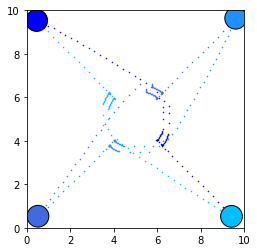

In [ ]:
# Single experiment
r1, r2, r3, r4 = simulate(algorithm=ALGORITHM)

if UNSAFE_PATH > 5:
    print(f'Failed to find a safe path! {UNSAFE_PATH} insecurities! Check the video to find out what happened.\n')
else:
    print(f'Safe Path found! {UNSAFE_PATH} insecurities! Let\'s create a video of the solution!\n')

create_video(ALGORITHM +'_extension.mp4')

## NMPC Costs

In [ ]:
selected_cost1 = []
selected_cost2 = []
selected_cost3 = []
selected_cost4 = []

for i, c in enumerate(selected_cost):
  if i % 4 == 0:
    selected_cost1.append(c)
  elif i % 4 == 1:
    selected_cost2.append(c)
  elif i % 4 == 2:
    selected_cost3.append(c)
  elif i % 4 == 3:
    selected_cost4.append(c)

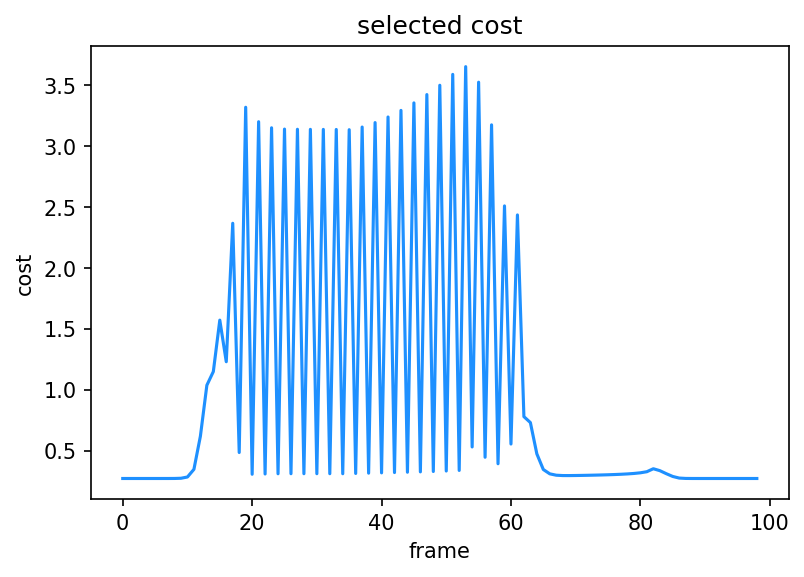

In [ ]:
# use this after a single experiment
# plot the cost of the velocity chosen in every timestep
plt.figure(dpi=150)
plt.plot(selected_cost1, 'dodgerblue')
plt.title('selected cost')
plt.ylabel('cost')
plt.xlabel('frame')
plt.show()

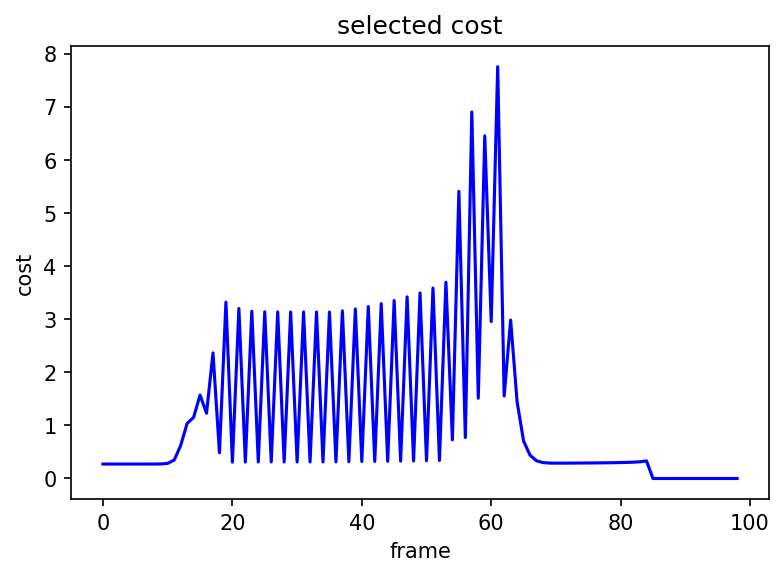

In [ ]:
plt.figure(dpi=150)
plt.plot(selected_cost2, 'blue')
plt.title('selected cost')
plt.ylabel('cost')
plt.xlabel('frame')
plt.show()

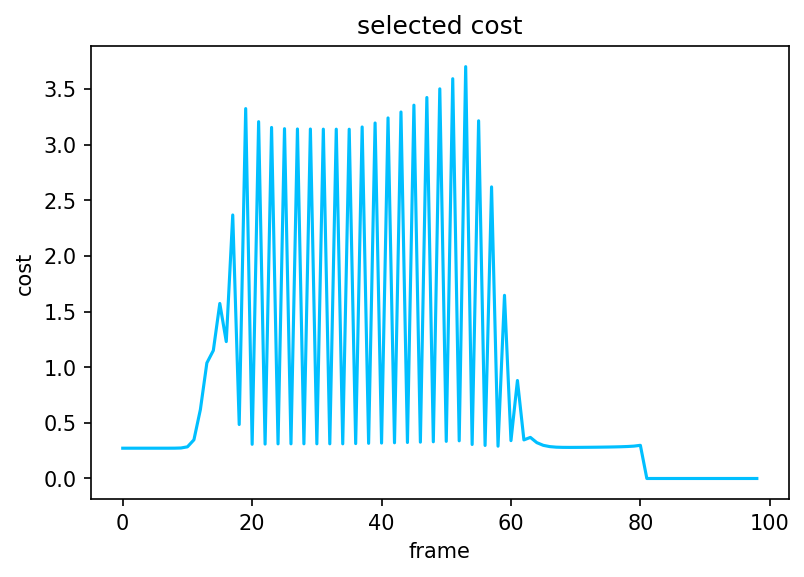

In [ ]:
plt.figure(dpi=150)
plt.plot(selected_cost3, 'deepskyblue')
plt.title('selected cost')
plt.ylabel('cost')
plt.xlabel('frame')
plt.show()

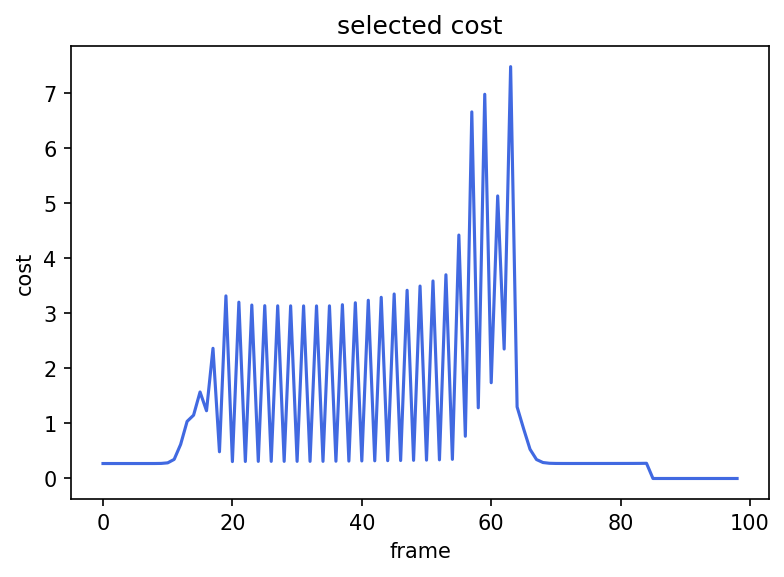

In [ ]:
plt.figure(dpi=150)
plt.plot(selected_cost4, 'royalblue')
plt.title('selected cost')
plt.ylabel('cost')
plt.xlabel('frame')
plt.show()